# HW6 - Q1

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
P1_widths = [300]
P1_spacing = 5
P1_material_idxs = [1]

P2_widths = [25, 250, 25]
P2_spacing = 5
P2_material_idxs = [5, 2, 5]

P3_widths = [25, 250, 25]
P3_spacing = 1
P3_material_idxs = [5, 2, 5]

P4_widths = [25, 15, 220, 15, 25]
P4_spacing = 1
P4_material_idxs = [5, 4, 3, 4, 5]

P5_widths = [23, 2, 15, 220, 15, 2, 23]
P5_spacing = 1
P5_material_idxs = [7, 6, 4, 3, 4, 6, 7]


#shift all material indexes

P1_material_idxs = [i-1 for i in P1_material_idxs]
P2_material_idxs = [i-1 for i in P2_material_idxs]
P3_material_idxs = [i-1 for i in P3_material_idxs]
P4_material_idxs = [i-1 for i in P4_material_idxs]
P5_material_idxs = [i-1 for i in P5_material_idxs]


material_1 = {
    "D1": 1.43,
    "D2": 0.37,
    "A1": 0.0079,
    "A2": 0.0605,
    "S12": 0.0195,  
    "NF1": 0.0034,
    "NF2": 0.0711
}

material_2 = {
    "D1": 1.43,
    "D2": 0.37,
    "A1": 0.0084,
    "A2": 0.0741,
    "S12": 0.0185,  
    "NF1": 0.0054,
    "NF2": 0.1
}

material_3 = {
    "D1": 1.43,
    "D2": 0.37,
    "A1": 0.0089,
    "A2": 0.0862,
    "S12": 0.0178,  
    "NF1": 0.0054,
    "NF2": 0.1
}

material_4 = {
    "D1": 1.43,
    "D2": 0.37,
    "A1": 0.0088,
    "A2": 0.0852,
    "S12": 0.0188,  
    "NF1": 0.0062,
    "NF2": 0.1249
}

material_5 = {
    "D1": 1.26,
    "D2": 0.27,
    "A1": 0.0025,
    "A2": 0.02,
    "S12": 0.0294,  
    "NF1": 0.0,
    "NF2": 0.0
}

material_6 = {
    "D1": 1.0,
    "D2": 0.34,
    "A1": 0.0054,
    "A2": 0.13,
    "S12": 0.0009,  
    "NF1": 0.0,
    "NF2": 0.0
}

material_7 = {
    "D1": 1.55,
    "D2": 0.27,
    "A1": 0.001,
    "A2": 0.0286,
    "S12": 0.045,  
    "NF1": 0.0,
    "NF2": 0.0
}

materials=[material_1, material_2, material_3, material_4, material_5, material_6, material_7]



In [118]:
def mesh(widths, spacing, material_idxs):
    n_mesh = int(np.sum(widths)/spacing)
    material_mesh = np.zeros(n_mesh)
    pos = 0
    for i in range(len(widths)):
        for j in range(int(widths[i]/spacing)):
            material_mesh[pos] = material_idxs[i]
            pos += 1
            
    return material_mesh.astype('int')

In [343]:
def build_FD_matrices(material_mesh, spacing):
    # define effective diffusion coefficients (D_tilde)
    D1_tildes = []
    D2_tildes = []
    
    for i in range(len(material_mesh)-1):
        # group 1
        D1_n = materials[material_mesh[i]]["D1"]    # D1 at n
        D1_n1 = materials[material_mesh[i+1]]["D1"] # D1 at n+1
        D1_tilde = 2*D1_n*D1_n1/spacing/(D1_n + D1_n1)
        D1_tildes.append(D1_tilde)
        #group 2
        D2_n = materials[material_mesh[i]]["D2"]    # D2 at n
        D2_n1 = materials[material_mesh[i+1]]["D2"] # D2 at n+1
        D2_tilde = 2*D2_n*D2_n1/spacing/(D2_n + D2_n1)
        D2_tildes.append(D2_tilde)
    
    
    ########################################################## MATRIX H
    H = np.zeros([len(material_mesh)*2, len(material_mesh)*2])
    
    # populate group 1 (fast)
    for i in range(1,len(material_mesh)-1):
        mat = materials[material_mesh[i]]
        H[i][i-1] = -D1_tildes[i-1]
        H[i][i+1] = -D1_tildes[i]
        H[i][i] = (mat["A1"] + mat["S12"])*spacing + D1_tildes[i-1] + D1_tildes[i]
        
    # populate group 2 (thermal)
    for i in range(len(material_mesh)+1,len(material_mesh)*2-1):
        mat = materials[material_mesh[i-len(material_mesh)]]
        H[i][i-1] = -D2_tildes[i-1-len(material_mesh)]
        H[i][i+1] = -D2_tildes[i-len(material_mesh)]
        H[i][i] = mat["A2"]*spacing + D2_tildes[i-1-len(material_mesh)] + D2_tildes[i-len(material_mesh)]
        H[i][i-len(material_mesh)] = -mat["S12"]*spacing
        
        
        
    ########################################################## MATRIX F
    F = np.zeros([len(material_mesh)*2, len(material_mesh)*2])
    
    # populate group 1 (fast)
    for i in range(1,len(material_mesh)-1):
        mat = materials[material_mesh[i]]
        F[i][i] = mat["NF1"]*spacing
        F[i][i+len(material_mesh)] = mat["NF2"]*spacing
               
    # populate group 2 (thermal)

    
    ########################################################## BOUNDARY CONDITIONS
    H[0,0] = 1
    H[len(material_mesh)-1, len(material_mesh)-1] = 1
    H[len(material_mesh), len(material_mesh)] = 1
    H[2*len(material_mesh)-1, 2*len(material_mesh)-1] = 1
    
    return H, F

In [344]:
def RMS(array_new, array_old):
    RMS_vec = np.square(np.divide(np.subtract(array_new, array_old), array_new))
    RMS = np.sqrt(np.nanmean(RMS_vec))
    return RMS

In [345]:
def FD_solver(H, F):
    # initialize unkown vector (flux vector) and eigenvalue
    f_old = np.ones(len(H))
    f_old = f_old/np.sum(f_old)
    k_old = 1
    
    for i in range(10000):
        r_old = F.dot(f_old)/k_old
        f_new = np.linalg.solve(H,r_old)
        r_new = F.dot(f_new)/k_old
        k_new = k_old*np.sum(r_new)/np.sum(r_old)
        
        if (RMS(r_new, r_old) < 1e-7) and (RMS(f_new, f_old) < 1e-5):
            f_new = f_new/np.sum(f_new)
            f_old = f_new
            k_old = k_new
            break
        
        f_new = f_new/np.sum(f_new)
        f_old = f_new
        k_old = k_new
    
    print("k: {:.3f}  -  # iterations: {}".format(k_old, i+1))
        
    return k_new, f_new, r_new[:int(len(H)/2)]/np.mean(r_new[:int(len(H)/2)]), i+1

In [346]:
def distance_from_center(mesh_position, material_mesh, spacing):
    d = (mesh_position-len(material_mesh)/2)*spacing
    if abs(d) == spacing:
        d=0
    return d

.

.

# SIMULATIONS

In [347]:
# Solve problem 1 analytically

from sympy import symbols, solve
m = materials[0]
Bg = (np.pi/300)**2
k = symbols('k')
M = [[m["D1"]*Bg + m["A1"] + m["S12"] -m["NF1"]/k, -m["NF2"]/k], [-m["S12"], m["D2"]*Bg + m["A2"]]]
det = M[0][0]*M[1][1] - M[0][1]*M[1][0]
sol = solve(det)
print("Analytical solution of eigenvalue for P1: {:.3f}".format(sol[0]))

Analytical solution of eigenvalue for P1: 0.954


In [348]:
P1_material_mesh = mesh(P1_widths, P1_spacing, P1_material_idxs)
H1, F1 = build_FD_matrices(P1_material_mesh, P1_spacing)
k1, f1, r1, it1 = FD_solver(H1, F1)
f1=np.array_split(f1/P1_spacing,2)

# find peak and peak location of normalized fission source
r1_max = np.max(r1)
r1_peak = distance_from_center(np.argmax(r1), P1_material_mesh, P1_spacing)

k: 0.954  -  # iterations: 247


/var/folders/c2/qplk8q1902b34cmtymk38ppw0000gn/T/ipykernel_59957/911040851.py:2: RuntimeWarning: invalid value encountered in divide
  RMS_vec = np.square(np.divide(np.subtract(array_new, array_old), array_new))


In [349]:
P2_material_mesh = mesh(P2_widths, P2_spacing, P2_material_idxs)
H2, F2 = build_FD_matrices(P2_material_mesh, P2_spacing)
k2, f2, r2, it2 = FD_solver(H2, F2)
f2=np.array_split(f2/P2_spacing,2)

# find peak and peak location of normalized fission source
r2_max = np.max(r2)
r2_peak = distance_from_center(np.argmax(r2), P2_material_mesh, P2_spacing)

k: 1.120  -  # iterations: 209


/var/folders/c2/qplk8q1902b34cmtymk38ppw0000gn/T/ipykernel_59957/911040851.py:2: RuntimeWarning: invalid value encountered in divide
  RMS_vec = np.square(np.divide(np.subtract(array_new, array_old), array_new))


In [350]:
P3_material_mesh = mesh(P3_widths, P3_spacing, P3_material_idxs)
H3, F3 = build_FD_matrices(P3_material_mesh, P3_spacing)
k3, f3, r3, it3 = FD_solver(H3, F3)
f3=np.array_split(f3/P3_spacing,2)

# find peak and peak location of normalized fission source
r3_max = np.max(r3)
r3_peak = distance_from_center(np.argmax(r3), P3_material_mesh, P3_spacing)

/var/folders/c2/qplk8q1902b34cmtymk38ppw0000gn/T/ipykernel_59957/911040851.py:2: RuntimeWarning: invalid value encountered in divide
  RMS_vec = np.square(np.divide(np.subtract(array_new, array_old), array_new))


k: 1.120  -  # iterations: 212


/var/folders/c2/qplk8q1902b34cmtymk38ppw0000gn/T/ipykernel_59957/911040851.py:2: RuntimeWarning: divide by zero encountered in divide
  RMS_vec = np.square(np.divide(np.subtract(array_new, array_old), array_new))


In [351]:
P4_material_mesh = mesh(P4_widths, P4_spacing, P4_material_idxs)
H4, F4 = build_FD_matrices(P4_material_mesh, P4_spacing)
k4, f4, r4, it4 = FD_solver(H4, F4)
f4=np.array_split(f4/P4_spacing,2)

# find peak and peak location of normalized fission source
r4_max = np.max(r4)
r4_peak = distance_from_center(np.argmax(r4), P4_material_mesh, P4_spacing)

/var/folders/c2/qplk8q1902b34cmtymk38ppw0000gn/T/ipykernel_59957/911040851.py:2: RuntimeWarning: invalid value encountered in divide
  RMS_vec = np.square(np.divide(np.subtract(array_new, array_old), array_new))


k: 0.978  -  # iterations: 304


In [354]:
P5_material_mesh = mesh(P5_widths, P5_spacing, P5_material_idxs)
H5, F5 = build_FD_matrices(P5_material_mesh, P5_spacing)
k5, f5, r5, it5 = FD_solver(H5, F5)
f5=np.array_split(f5/P5_spacing,2)

# find peak and peak location of normalized fission source
r5_max = np.max(r5)
r5_peak = distance_from_center(np.argmax(r5), P5_material_mesh, P5_spacing)

/var/folders/c2/qplk8q1902b34cmtymk38ppw0000gn/T/ipykernel_59957/911040851.py:2: RuntimeWarning: invalid value encountered in divide
  RMS_vec = np.square(np.divide(np.subtract(array_new, array_old), array_new))


k: 0.973  -  # iterations: 275


/var/folders/c2/qplk8q1902b34cmtymk38ppw0000gn/T/ipykernel_59957/911040851.py:2: RuntimeWarning: divide by zero encountered in divide
  RMS_vec = np.square(np.divide(np.subtract(array_new, array_old), array_new))


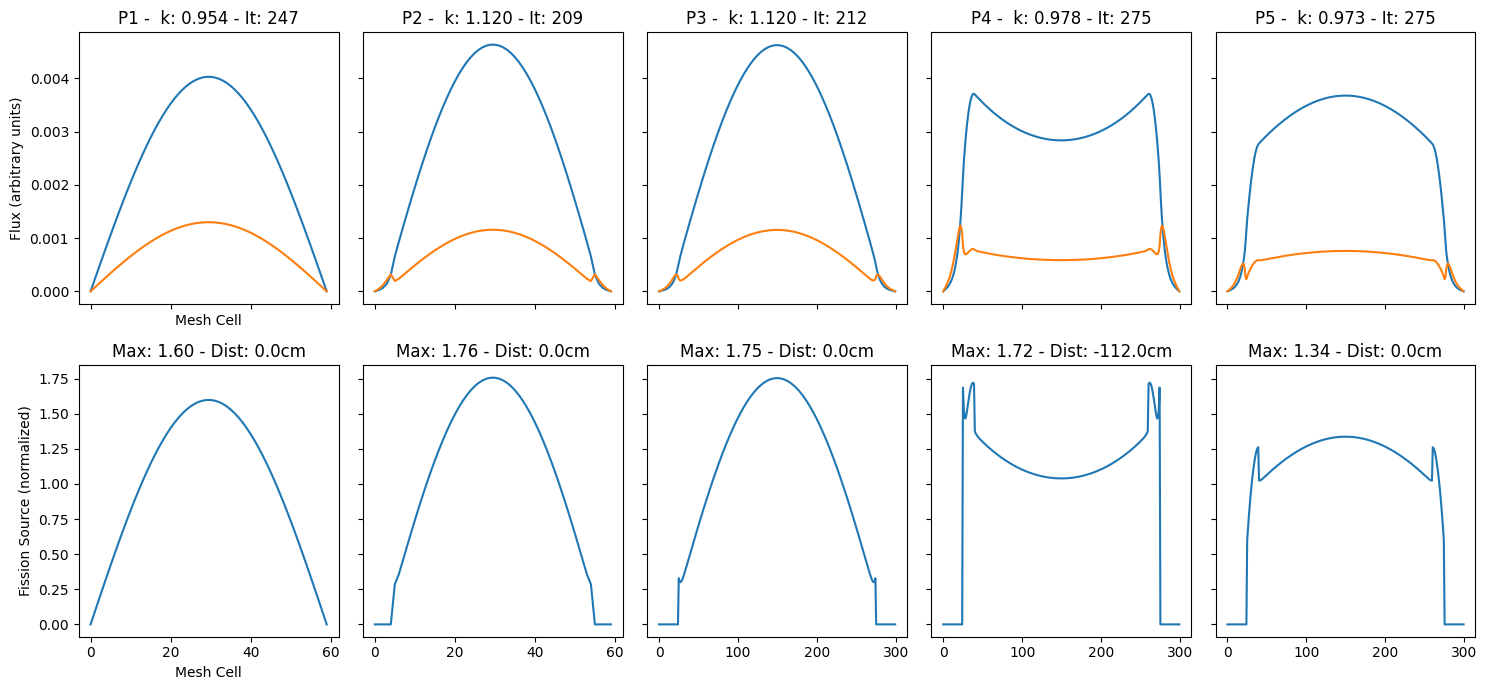

In [355]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,7), sharex='col', sharey='row')

ax[0][0].plot(f1[0], label='Fast')
ax[0][0].plot(f1[1], label='Thermal')
ax[0][0].set_ylabel("Flux (arbitrary units)")
ax[0][0].set_xlabel("Mesh Cell")
ax[0][0].set_title("P1 -  k: {:.3f} - It: {}".format(k1, it1))

ax[0][1].plot(f2[0], label='Fast')
ax[0][1].plot(f2[1], label='Thermal')
ax[0][1].set_title("P2 -  k: {:.3f} - It: {}".format(k2, it2))

ax[0][2].plot(f3[0], label='Fast')
ax[0][2].plot(f3[1], label='Thermal')
ax[0][2].set_title("P3 -  k: {:.3f} - It: {}".format(k3, it3))

ax[0][3].plot(f4[0], label='Fast')
ax[0][3].plot(f4[1], label='Thermal')
ax[0][3].set_title("P4 -  k: {:.3f} - It: {}".format(k4, it4))

ax[0][4].plot(f5[0], label='Fast')
ax[0][4].plot(f5[1], label='Thermal')
ax[0][4].set_title("P5 -  k: {:.3f} - It: {}".format(k5, it5))

ax[1][0].plot(r1, label='Fast')
ax[1][0].set_ylabel("Fission Source (normalized)")
ax[1][0].set_xlabel("Mesh Cell")
ax[1][0].set_title("Max: {:.2f} - Dist: {:.1f}cm".format(r1_max, r1_peak))

ax[1][1].plot(r2/np.mean(r2), label='Fast')
ax[1][1].set_title("Max: {:.2f} - Dist: {:.1f}cm".format(r2_max, r2_peak))

ax[1][2].plot(r3/np.mean(r3), label='Fast')
ax[1][2].set_title("Max: {:.2f} - Dist: {:.1f}cm".format(r3_max, r3_peak))

ax[1][3].plot(r4/np.mean(r4), label='Fast')
ax[1][3].set_title("Max: {:.2f} - Dist: {:.1f}cm".format(r4_max, r4_peak))

ax[1][4].plot(r5/np.mean(r5), label='Fast')
ax[1][4].set_title("Max: {:.2f} - Dist: {:.1f}cm".format(r5_max, r5_peak))

plt.tight_layout()
plt.savefig("results_FD.jpg", dpi=1000)

In [359]:
print("Reactivity Change bewteen P4-5: {:.0f} pcm".format((1/k4 - 1/k5)*1e5))

Reactivity Change bewteen P4-5: -531 pcm


## COMMENTS:

   - P1: shows good agreement with analytical solution
   - P2-3: solution 2 was converged already with coarser mesh
   - P4-5: modeling the baffle and reflector as separate entities reduces k slightly (reactivity insertion of 531 pcm) but most importantly reverses flux convexity

.

.

.

## RESULTS

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4), sharey=True)

ax[0].plot([i[0] for i in phi_P1], label='Fast')
ax[0].plot([i[1] for i in phi_P1], label='Thermal')
ax[0].set_ylabel("Flux (arbitrary units)")
ax[0].set_xlabel("Mesh Cell")
ax[0].legend()
ax[0].set_title("P1 -  k: {:.3f}".format(k_P1))

ax[1].plot([i[0] for i in phi_P2], label='Fast')
ax[1].plot([i[1] for i in phi_P2], label='Thermal')
ax[1].legend()
ax[1].set_title("P2 -  k: {:.3f}".format(k_P2))

ax[2].plot([i[0] for i in phi_P3], label='Fast')
ax[2].plot([i[1] for i in phi_P3], label='Thermal')
ax[2].legend()
ax[2].set_title("P3 -  k: {:.3f}".format(k_P3))

plt.savefig("results_MOC.jpg", dpi=1000)